<h1> Speech Rap Signing Classification</h1>

Data source: see my SRS_classifier.ipynb notebook

In [1]:
import numpy as np
import json
import librosa
import os
import time
import math

<h2>Data Preperation</h2>
First we cycle through the data and interpret the music files as MFCCs. MFCCs and their semantic labels are then stored in a .json file.

In [2]:
"""
@param dataset_path: relative location of the dataset.
@param json_path:
@param n_mfcc: number of mfcc variables to receive
@param hop_length: how far along to move the window
@param num_segments: how many parts to break each file into

"""
def create_mfcc_data(dataset_path, n_mfcc=13, n_fft=2048, hop_length=512, semanticLabelFolderLocation=-2,
              num_segments=5, sample_rate=20000,allLabels={"speech":0,"rap":1,"singing":2},duration = 3):
    #dictionary to store data
    # - mapping: mapp labels to values
    # - labels: target
    data={
        "mapping":[],
        "mfcc":[],
        "labels":[]
    }
    #the length of each sample, we know this for this dataset. Could be calculated dynamically
    
    samples_per_track = sample_rate * duration
    #how many data points we expect to appear in each segment we break our track into
    num_samples_per_segment = int(samples_per_track/num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/ hop_length)
    
    print ("num_samples_per_segment",num_samples_per_segment)
    #loop through all the genres
    #dirpath: folder we are currently in
    #dirnames: all the names of the subfolders
    #filenames: all the filenames
    #i: the count. It MUST be included
    #os.walk returns a generator, that creates a tuple of values: 
    #(current_path, directories in current_path, files in current_path).
    # - each iteration is a different genre
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        #ensure we're not yet at the dataset level
        if dirpath is not dataset_path:
            #save the semantic label (the mappings etc)
            #dirpath_components: the individual folder names that make up the full path
            dirpath_components = dirpath.split("\\") #genre/blues => ["genre","blues"]
            semantic_label = dirpath_components[semanticLabelFolderLocation]
            #use the parent directory of a sound file as its label
            data["mapping"].append(semantic_label)
            for f in filenames:
                # load audio file : the path of the file is just its directory path plus its name
                file_path = os.path.join(dirpath,f)
                signal, sr = librosa.load(file_path,sr=sample_rate)
                #process segments to extract MFCC and store data
                for s in range (0, num_segments):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment
                    #the mfcc for data points between start_sample and finish_sample
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],sr=sr,n_fft=n_fft,n_mfcc=n_mfcc, hop_length = hop_length)
                    mfcc=mfcc.T
                    #store mfcc for segement if it has the expected length
                    if len(mfcc)==expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        # first iteration was the dataset path
                        correctLabel = allLabels[semantic_label]
                        data["labels"].append(correctLabel)
    return data

In [3]:
def save_mfcc_data(data,json_path):
    #save what we have created as a jason file
    with open(json_path,"w") as fp:
        json.dump(data,fp,indent=4)  

In [4]:
DATASET_PATH_TEST="./data_seperate_test"
DATASET_PATH_TRAIN="./data_seperate_train"
JSON_PATH_TEST="data_test.json"
JSON_PATH_TRAIN="data_train.json"
SAMPLE_RATE = 16000
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH=512
NUM_SEGMENTS = 1
ALLLABELS={"speech":0,"rap":1,"singing":2}
DURATION = 3
SEMANTICLABELFOLDERLOCATION=-2

startTime = time.perf_counter()
data_train=create_mfcc_data(dataset_path=DATASET_PATH_TRAIN, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH, 
                      semanticLabelFolderLocation=SEMANTICLABELFOLDERLOCATION, num_segments=NUM_SEGMENTS, 
                      sample_rate=SAMPLE_RATE,allLabels=ALLLABELS,duration = DURATION)
startTime = time.perf_counter()
data_test=create_mfcc_data(dataset_path=DATASET_PATH_TEST, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH, 
                      semanticLabelFolderLocation=SEMANTICLABELFOLDERLOCATION, num_segments=NUM_SEGMENTS, 
                      sample_rate=SAMPLE_RATE,allLabels=ALLLABELS,duration = DURATION)

save_mfcc_data(data_test,JSON_PATH_TEST)
save_mfcc_data(data_train,JSON_PATH_TRAIN)
endTime = time.perf_counter()

print ("Run Complete. Time taken:",endTime-startTime)

num_samples_per_segment 48000
num_samples_per_segment 48000
Run Complete. Time taken: 8.3705385




We use the same MFCC data drawn at 16000 samples per second as we generated for the multi-layer perceptron approach used previously (see SRS_classifier.ipynb).

Data structure:

$x.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables})$

$x_i.\texttt{shape} = (\text{num time intervals}, \text{num mfcc variables}))$


$y.\texttt{shape}=(\text{num labels})$

$y_i=\text{label}$

where $\text{label} \in \{1,2,3\}$

In [5]:
#load data from the file
#split data into training and test
"""
load data from a json file with objects "mfcc" and "labels"
@param dataset_path: path to the json file
@return np array of mfcc data, np array of target values
"""
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
        inputs=np.array(data["mfcc"])
        targets=np.array(data["labels"])
        return inputs,targets


<h3>Load the data</h3>
Load the data from the jason file and verify that the inputs are of the expected type, and the sample size is as expected, in this case: 480 samples of each label.


In [6]:
x_train,y_train = load_data("data_train.json")
x_test,y_test=load_data("data_test.json")
x_test

print ("train shape", x_train.shape)
print ("test shape", x_test.shape)

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the y_train targets:")
print(np.asarray((unique_elements, counts_elements)))

unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print("Frequency of unique values of the y_test targets:")
print(np.asarray((unique_elements, counts_elements)))

train shape (1068, 94, 13)
test shape (372, 94, 13)
Frequency of unique values of the y_train targets:
[[  0   1   2]
 [291 406 371]]
Frequency of unique values of the y_test targets:
[[  0   1   2]
 [189  74 109]]


In [7]:
#shuffle the train arrays
shuffler_train = np.random.permutation(len(x_train))
x_train = x_train[shuffler_train]
y_train = y_train[shuffler_train]
#shuffle the test arrays
shuffler_test = np.random.permutation(len(x_test))
x_test = x_test[shuffler_test]
y_test = y_test[shuffler_test]



<h3>Create training, validation and test datasets</h3>
<ul>
    <li><b>training</b>: used to train the model.</li>
    <li><b>validation</b>: used to evaluate the model after training.</li>
    <li><b>test</b>: used to evaluate a model that does well on validation. Ensures that the ML engineer has not been inadvertantly tweaking his model to work on the validation set alone, rather than generalising.</li>
    </ul>
    
Here we also add another axis/dimension to our input, giving each training sample a channel depth of 1. (Our CNN will require 3D samples as input). Our labels do not change.

In [8]:
"""
from sklearn.model_selection import train_test_split
def prepare_datasets(x,y,test_size,validation_size,dataset_path):
    #test set: test on the fully trained model
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size)
    #validation: test on unseen data, but model may end up learning it as we tweak to maximise validation accuracy
    x_train,x_validation,y_train,y_validation=train_test_split(x_train,y_train,test_size=validation_size)
    x_train=x_train[...,np.newaxis]
    x_validation=x_validation[...,np.newaxis]
    x_test=x_test[...,np.newaxis]
    return x_train,x_test,y_train,y_test, x_validation, y_validation  
"""

'\nfrom sklearn.model_selection import train_test_split\ndef prepare_datasets(x,y,test_size,validation_size,dataset_path):\n    #test set: test on the fully trained model\n    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size)\n    #validation: test on unseen data, but model may end up learning it as we tweak to maximise validation accuracy\n    x_train,x_validation,y_train,y_validation=train_test_split(x_train,y_train,test_size=validation_size)\n    x_train=x_train[...,np.newaxis]\n    x_validation=x_validation[...,np.newaxis]\n    x_test=x_test[...,np.newaxis]\n    return x_train,x_test,y_train,y_test, x_validation, y_validation  \n'

Data structure:

$x_{train}.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables},\text{depth})$

$x_{validate}.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables},\text{depth})$

$x_{test}.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables},\text{depth})$



Where $\text{depth}=1$

In [9]:
#x_train,x_test,y_train,y_test, x_validation, y_validation = prepare_datasets(x,y,0.25,0.2, "data.json")

In [10]:
#(num samples, num intervals, num variables, num channels)
#x_train.shape

<h2>Models</h2>
<h3>Model Design 1: Convolutional Neural Network</h3>
For this model, I opt for a traditional CNN design: three pooled convolutional layers, followed by a single fully connected layer and an output layer, implemented in Tensorflow's Keras environment.

In [11]:
import tensorflow.keras as keras
"""
Creates a model of three pooled convolutional layers, followed by a single fully connected layer and an output layer.
@param input_shape: the structure of SINGLE value x_i (omits the first dimension of x which is the total number of samples.)
@return uncompiled keras model of the CNN.
"""
def build_model_cnn(input_shape,dropout_rate=0):
    model=keras.Sequential()
    #CONV LAYER 1
    model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2), padding='same'))
    #Batch normalisation: process that normalises the activations in the current layer for output to the next layer.
    #Speeds up training (faster convergence) and reliability.
    model.add(keras.layers.BatchNormalization())

    #CONV LAYER 2
    model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())   

    #CONV LAYER 3
    # we shrink the kernal size
    model.add(keras.layers.Conv2D(filters=32,kernel_size=(2,2),activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization()) 

    #flatten into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64,activation="relu"))
    model.add(keras.layers.Dropout(dropout_rate))  
    
    #output layer
    #a fully connected layer for classification
    NUMBEROFPOSSIBLEOUTPUTS=3
    model.add(keras.layers.Dense(NUMBEROFPOSSIBLEOUTPUTS,activation='softmax'))
    
    return model

In [12]:
#each sample has the shape (n,130,13,1) <- (num samples,intervals,variables,channels)
x_train_cnn=x_train[...,np.newaxis]
x_test_cnn=x_test[...,np.newaxis]
input_shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3])
model_cnn = build_model_cnn(input_shape,dropout_rate=0.4)

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 11, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 1, 32)         4

In [13]:
#Adam is a very very effecting sgd variant for deep learning
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#put all the components together
model_cnn.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )

<h3>Model Design 2: Dense Neural Netowrk</h3>
For this model, I opt for a traditional MLP design: three hidden convolutional layers and an output layer, implemented in Tensorflow's Keras environment.

In [14]:
def build_model_dense(input_shape,dropout_rate=0):
    model=keras.Sequential()
    #Flatten Layer
    model.add(keras.layers.Flatten(input_shape=input_shape))
    #Dense Layer 1
    model.add(keras.layers.Dense(512,activation="relu"))
    model.add(keras.layers.Dropout(dropout_rate))
    #Dense Layer 2
    model.add(keras.layers.Dense(256,activation="relu"))
    model.add(keras.layers.Dropout(dropout_rate))              
    #Dense Layer 3
    model.add(keras.layers.Dense(64,activation="relu"))
    model.add(keras.layers.Dropout(dropout_rate))
    #Output Layer
    NUMOUTPUTS=3
    model.add(keras.layers.Dense(NUMOUTPUTS,activation="softmax"))
    return model

In [15]:
input_shape_dense=(x_train.shape[1],x_train.shape[2])
model_dense = build_model_dense(input_shape=input_shape, dropout_rate=0.1)
model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1222)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               626176    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [16]:
#Adam is a very very effecting sgd variant for deep learning
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#put all the components together
model_dense.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )

<h3>Model Design 3: Long Short Term Memory</h3>
For this model, I opt for a two-deep LTSM followed by a dense and output layer.

In [17]:
"""
Creates a model of two pooled LSTM nodes. These are unwrapped and used to learn predictive state information.
"""
def build_model_lstm(input_shape,dropoutRate=0):
    model=keras.Sequential()
    
    #LSTM Layer 1
    #return_sequences = True: sequence to sequence layer, otherwise sequence to vector
    model.add(keras.layers.LSTM(units=64,activation='tanh',input_shape=input_shape,return_sequences=True))
    #LSTM Layer 2
    model.add(keras.layers.LSTM(units=64,activation='tanh',input_shape=input_shape,return_sequences=False))
    
    #pipe output into a dense layer. No need to flatten because sequence to vector
    model.add(keras.layers.Dense(units=64,activation='relu'))
    model.add(keras.layers.Dropout(dropoutRate))
    
    #output layer
    #a fully connected layer for classification
    NUMBEROFPOSSIBLEOUTPUTS=3
    model.add(keras.layers.Dense(NUMBEROFPOSSIBLEOUTPUTS,activation='softmax'))
    return model

In [18]:
#each sample has the shape (num samples,intervals,variables,channels=1)
input_shape=(x_train.shape[1], x_train.shape[2])
model_lstm = build_model_lstm(input_shape,dropoutRate=0.4)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 94, 64)            19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 57,347
Trainable params: 57,347
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Adam is a very very effecting sgd variant for deep learning
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#put all the components together
model_lstm.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )

<h3>Compiling the model</h3>
<ul><b>Optimizer</b>: Adam</ul>
<ul><b>Loss Function</b>: sparse_categorical_crossentropy - a powerful tool for categorization tasks.</ul>
<ul><b>Metrics</b>: accuracy</ul>

In [20]:
print(x_train_cnn.shape)
print(x_test_cnn.shape)

(1068, 94, 13, 1)
(372, 94, 13, 1)


<h2>Training the Models</h2>
We fit the model to our training data and validate it against our validation data.

In [21]:
#stores the progression of several metrics as the model trains.
import time
startTime = time.perf_counter()

history_cnn = model_cnn.fit(x_train_cnn,y_train,validation_data=(x_test_cnn,y_test),epochs=50)
endTime = time.perf_counter()

print ("Run Complete. Time taken:",endTime-startTime)

Epoch 1/50
34/34 [==============================] - 0s 13ms/step - loss: 1.3543 - accuracy: 0.4551 - val_loss: 1.6738 - val_accuracy: 0.5108
Epoch 2/50
34/34 [==============================] - 0s 9ms/step - loss: 0.9623 - accuracy: 0.5974 - val_loss: 1.2056 - val_accuracy: 0.5430
Epoch 3/50
34/34 [==============================] - 0s 9ms/step - loss: 0.7646 - accuracy: 0.6807 - val_loss: 0.8418 - val_accuracy: 0.6452
Epoch 4/50
34/34 [==============================] - 0s 10ms/step - loss: 0.6059 - accuracy: 0.7500 - val_loss: 0.5979 - val_accuracy: 0.7796
Epoch 5/50
34/34 [==============================] - 0s 9ms/step - loss: 0.4881 - accuracy: 0.8024 - val_loss: 0.4471 - val_accuracy: 0.8253
Epoch 6/50
34/34 [==============================] - 0s 9ms/step - loss: 0.4146 - accuracy: 0.8305 - val_loss: 0.3402 - val_accuracy: 0.8629
Epoch 7/50
34/34 [==============================] - 0s 10ms/step - loss: 0.3741 - accuracy: 0.8558 - val_loss: 0.2596 - val_accuracy: 0.8978
Epoch 8/50
34/34 

In [22]:
import time
startTime = time.perf_counter()
history_dense = model_dense.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=50, batch_size=32)
endTime = time.perf_counter()
print ("Run Complete. Time taken:",endTime-startTime)

Epoch 1/50
34/34 [==============================] - 0s 4ms/step - loss: 29.4808 - accuracy: 0.5056 - val_loss: 6.6824 - val_accuracy: 0.7554
Epoch 2/50
34/34 [==============================] - 0s 2ms/step - loss: 12.7250 - accuracy: 0.6526 - val_loss: 5.7731 - val_accuracy: 0.7769
Epoch 3/50
34/34 [==============================] - 0s 2ms/step - loss: 9.1221 - accuracy: 0.6760 - val_loss: 5.4150 - val_accuracy: 0.7500
Epoch 4/50
34/34 [==============================] - 0s 2ms/step - loss: 6.4489 - accuracy: 0.7154 - val_loss: 4.6030 - val_accuracy: 0.7688
Epoch 5/50
34/34 [==============================] - 0s 2ms/step - loss: 5.0493 - accuracy: 0.7481 - val_loss: 3.6539 - val_accuracy: 0.7608
Epoch 6/50
34/34 [==============================] - 0s 2ms/step - loss: 3.6210 - accuracy: 0.7678 - val_loss: 3.4655 - val_accuracy: 0.7823
Epoch 7/50
34/34 [==============================] - 0s 2ms/step - loss: 3.5094 - accuracy: 0.7753 - val_loss: 3.3088 - val_accuracy: 0.7742
Epoch 8/50
34/34 [

In [23]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
#x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.1)

import time
startTime = time.perf_counter()
history_lstm = model_lstm.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)
endTime = time.perf_counter()
print ("Run Complete. Time taken:",endTime-startTime)

Epoch 1/50
34/34 [==============================] - 1s 39ms/step - loss: 1.1009 - accuracy: 0.3867 - val_loss: 1.0036 - val_accuracy: 0.6425
Epoch 2/50
34/34 [==============================] - 1s 26ms/step - loss: 1.0172 - accuracy: 0.5243 - val_loss: 0.9487 - val_accuracy: 0.7554
Epoch 3/50
34/34 [==============================] - 1s 25ms/step - loss: 0.9444 - accuracy: 0.6330 - val_loss: 0.8821 - val_accuracy: 0.7876
Epoch 4/50
34/34 [==============================] - 1s 27ms/step - loss: 0.8583 - accuracy: 0.7013 - val_loss: 0.7617 - val_accuracy: 0.7903
Epoch 5/50
34/34 [==============================] - 1s 27ms/step - loss: 0.7238 - accuracy: 0.7669 - val_loss: 0.6013 - val_accuracy: 0.8011
Epoch 6/50
34/34 [==============================] - 1s 27ms/step - loss: 0.5817 - accuracy: 0.8202 - val_loss: 0.5103 - val_accuracy: 0.8011
Epoch 7/50
34/34 [==============================] - 1s 27ms/step - loss: 0.4786 - accuracy: 0.8390 - val_loss: 0.5106 - val_accuracy: 0.8038
Epoch 8/50
34

<h2>Evaluating the Trained Model</h2>
We plot the history of the model across epochs with respect to accuracy and error using.

In [24]:
import matplotlib.pyplot as plt

It is clear that the model has trained well and consistently achieves accuracy above $97 \%$ on the validation set. It seems to converge to this value after about 20 epochs.

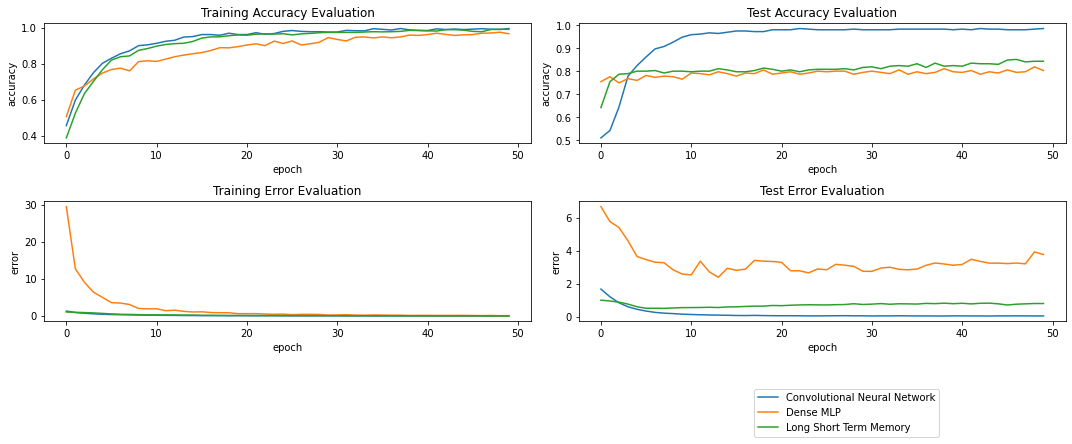

In [25]:
def plot_accuracy_histories(histories, labels):
    fig,axs = plt.subplots(2,2,figsize=(15,7))
    
    pos=0
    for history in histories:
        axs[0,0].plot(history.history["accuracy"],label="train accuracy {}".format((labels[pos])))
        pos=pos+1
    #loc sets location
    #axs[0,0].legend(loc="lower right")
    axs[0,0].set_title("Training Accuracy Evaluation")
    axs[0,0].set_ylabel("accuracy")
    axs[0,0].set_xlabel("epoch")
    pos=0
    
    for history in histories:
        axs[0,1].plot(history.history["val_accuracy"],label="test accuracy {}".format(labels[pos]))
        #loc sets location
        pos=pos+1
    #axs[0,1].legend(loc="lower right")
    axs[0,1].set_title("Test Accuracy Evaluation")
    axs[0,1].set_ylabel("accuracy")
    axs[0,1].set_xlabel("epoch")   
    pos=0
    
    for history in histories:
        axs[1,0].plot(history.history["loss"],label="train error {}".format(labels[pos]))
        pos=pos+1
    axs[1,0].set_ylabel("error")
    #loc sets location
    #axs[1,0].legend(loc="lower right")
    axs[1,0].set_title("Training Error Evaluation")
    axs[1,0].set_xlabel("epoch")
        
    pos=0
    for history in histories:
        #axs[1,1].plot(history.history["val_loss"],label="test error {}".format(labels[pos]))
        axs[1,1].plot(history.history["val_loss"],label="{}".format(labels[pos]))
        pos=pos+1
    axs[1,1].set_ylabel("error")
    #loc sets location
    axs[1,1].legend(bbox_to_anchor=(0.75, -1),loc="lower right")
    axs[1,1].set_title("Test Error Evaluation")
    axs[1,1].set_xlabel("error")
    axs[1,1].set_xlabel("epoch")
    #just keeps the images from overlapping
    fig.tight_layout() 
    #plt.show()
    plt.savefig('accuracyMeasures.png')

plot_accuracy_histories([history_cnn,history_dense,history_lstm],labels=["Convolutional Neural Network","Dense MLP","Long Short Term Memory"])